# Vietnamese Sentiment Analysis - UIT-VSFC Dataset

Phân tích cảm xúc (Sentiment Analysis) là bài toán phân loại văn bản theo cảm xúc của người viết. Trong ngữ cảnh tiếng Việt, đây là một thách thức đặc biệt do tính đa nghĩa, cấu trúc ngữ pháp linh hoạt và sự phong phú của ngữ cảnh văn hóa.

## Approach 2: PhoBERT Fine-tuning

PhoBERT là mô hình ngôn ngữ được tiền huấn luyện (pre-trained language model) dựa trên kiến trúc BERT, được tối ưu hóa đặc biệt cho tiếng Việt. Phương pháp này tận dụng tri thức ngôn ngữ đã học từ hàng tỷ từ tiếng Việt để chuyển giao (transfer learning) sang bài toán phân loại cảm xúc cụ thể.

### Cấu hình mô hình (Model Configuration)

**Mô hình nền (Base Model):**
- **Pretrained model:** `vinai/phobert-base`
  - Kiến trúc:  12 lớp Transformer (12-layer BERT)
  - Chiều embedding: 768 dimensions
  - Được huấn luyện trước trên corpus tiếng Việt lớn (20GB text)

**Định nghĩa bài toán:**
- **Input:** Các câu phản hồi của sinh viên (student feedback sentences)
- **Output:** 3 nhãn cảm xúc (sentiment labels):
  - `0`: Negative (Tiêu cực)
  - `1`: Neutral (Trung tính)
  - `2`: Positive (Tích cực)

### Tiền xử lý dữ liệu (Data Preprocessing)

**Tokenization (Tách từ):**
- Sử dụng **PhoBERT BPE Tokenizer** (Byte-Pair Encoding) được thiết kế riêng cho tiếng Việt
- **Max Length:** 128 tokens (tương đương khoảng 100-120 từ tiếng Việt)
- **Padding:** Đệm các câu ngắn hơn về độ dài 128 để đồng nhất batch
- **Truncation:** Cắt bớt các câu dài hơn 128 tokens (giữ lại phần đầu)

**Đặc điểm kỹ thuật:**
Mỗi câu đầu vào được chuyển thành chuỗi vector: 

## 1. Import libraries

In [1]:
# Core
import os
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup,
)

# Metrics
from sklearn.metrics import precision_recall_fscore_support

# Tùy chọn: tắt warning linh tinh
import warnings
warnings.filterwarnings("ignore")

# Kiểm tra thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cuda


## 2 Load data

In [2]:
def load_data(base_path, split='train'):
    """
    Load dữ liệu từ thư mục
    """
    path = f"{base_path}/{split}"
    
    with open(f"{path}/sents.txt", 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f]
    
    with open(f"{path}/sentiments.txt", 'r', encoding='utf-8') as f:
        sentiments = [int(line.strip()) for line in f]
    
    with open(f"{path}/topics.txt", 'r', encoding='utf-8') as f:
        topics = [int(line.strip()) for line in f]
    
    return sentences, sentiments, topics

DATA_PATH = "/kaggle/input/nlp-datasets/data"

train_sents, train_sentiments, train_topics = load_data(DATA_PATH, 'train')
dev_sents, dev_sentiments, dev_topics = load_data(DATA_PATH, 'dev')
test_sents, test_sentiments, test_topics = load_data(DATA_PATH, 'test')

print(f"Training: {len(train_sents)}, Dev: {len(dev_sents)}, Test: {len(test_sents)}")
print(train_sents[:5])
print(train_sentiments[:5])
print(train_topics[:5])

Training: 11426, Dev: 1583, Test: 3166
['slide giáo trình đầy đủ .', 'nhiệt tình giảng dạy , gần gũi với sinh viên .', 'đi học đầy đủ full điểm chuyên cần .', 'chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy .', 'thầy giảng bài hay , có nhiều bài tập ví dụ ngay trên lớp .']
[2, 2, 0, 0, 2]
[1, 0, 1, 0, 0]


## 3. Tính class_weights

In [3]:
import numpy as np

class_counts = np.bincount(train_sentiments)  # [neg, neu, pos]
num_classes = len(class_counts)
total = len(train_sentiments)
class_weights = total / (num_classes * class_counts)

print("Class counts:", class_counts)      
print("Class weights:", class_weights)    

Class counts: [5325  458 5643]
Class weights: [0.71524257 8.31586608 0.6749365 ]


## 4.  Khởi tạo tokenizer PhoBERT

In [4]:
from transformers import AutoTokenizer

MODEL_NAME = "vinai/phobert-base"
MAX_LEN = 128  # tăng lên so với 64 để đỡ cắt câu dài
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## 5 Định nghĩa Dataset

In [5]:
import torch
from torch.utils.data import Dataset

class VSFCSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

## 6.  Tạo DataLoader

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32  # có thể 16 nếu GPU hạn chế

train_dataset = VSFCSentimentDataset(train_sents, train_sentiments, tokenizer, MAX_LEN)
dev_dataset   = VSFCSentimentDataset(dev_sents,   dev_sentiments,   tokenizer, MAX_LEN)
test_dataset  = VSFCSentimentDataset(test_sents,  test_sentiments,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(dev_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(dev_loader), len(test_loader)

(358, 50, 99)

## 7 Định nghĩa model PhoBERT + class weights

In [7]:
import torch.nn as nn

class PhoBertSentiment(nn.Module):
    def __init__(self, model_name, num_labels, class_weights=None):
        super().__init__()
        self.phobert = AutoModel.from_pretrained(model_name)
        hidden_size = self.phobert.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)
        if class_weights is not None:
            self.loss_fct = nn.CrossEntropyLoss(
                weight=torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
            )
        else:
            self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]   # token [CLS]
        x = self.dropout(cls_emb)
        logits = self.classifier(x)
        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)
        return loss, logits

NUM_LABELS = len(set(train_sentiments))
model = PhoBertSentiment(MODEL_NAME, NUM_LABELS, class_weights=class_weights).to(DEVICE)

2025-12-18 14:19:44.148874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766067584.355669      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766067584.414198      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766067584.894979      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766067584.895012      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766067584.895015      55 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

## 8 Hàm eval (trả macro & weighted + per-class)

In [9]:
def eval_epoch(model, loader):
    model.eval()
    all_labels, all_preds = [], []
    total_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            loss, logits = model(input_ids, attention_mask, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    # macro
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    # weighted
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    # per-class
    p_c, r_c, f1_c, sup_c = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

    return total_loss / len(loader), (p_m, r_m, f1_m), (p_w, r_w, f1_w), (p_c, r_c, f1_c, sup_c)

 ## 9 Train loop (chọn best theo macro-F1)

In [10]:
BATCH_SIZE = 32
EPOCHS = 4
LR = 2e-5

optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

best_f1 = 0.0
best_model_path = "best_phobert_sentiment.pt"

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        model.zero_grad()
        loss, _ = model(input_ids, attention_mask, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    dev_loss, (p_m, r_m, f1_m), (p_w, r_w, f1_w), _ = eval_epoch(model, dev_loader)
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train loss: {total_loss/len(train_loader):.4f}")
    print(f"  Dev loss:   {dev_loss:.4f}")
    print(f"  Dev P/R/F1 (macro):    {p_m:.4f} / {r_m:.4f} / {f1_m:.4f}")
    print(f"  Dev P/R/F1 (weighted): {p_w:.4f} / {r_w:.4f} / {f1_w:.4f}")

    # Tiêu chí chọn best: macro-F1 (đề bài) — đổi thành f1_w nếu muốn so sát baseline
    if f1_m > best_f1:
        best_f1 = f1_m
        torch.save(model.state_dict(), best_model_path)
        print("  -> Saved best model.")
print("Best dev F1 (theo tiêu chí đang chọn):", best_f1)


Epoch 1/4
  Train loss: 0.6541
  Dev loss:   0.4454
  Dev P/R/F1 (macro):    0.8070 / 0.8251 / 0.8154
  Dev P/R/F1 (weighted): 0.9292 / 0.9267 / 0.9278
  -> Saved best model.

Epoch 2/4
  Train loss: 0.3563
  Dev loss:   0.5408
  Dev P/R/F1 (macro):    0.8547 / 0.8350 / 0.8440
  Dev P/R/F1 (weighted): 0.9391 / 0.9400 / 0.9392
  -> Saved best model.

Epoch 3/4
  Train loss: 0.2654
  Dev loss:   0.5507
  Dev P/R/F1 (macro):    0.8464 / 0.8540 / 0.8501
  Dev P/R/F1 (weighted): 0.9394 / 0.9387 / 0.9390
  -> Saved best model.

Epoch 4/4
  Train loss: 0.2042
  Dev loss:   0.6760
  Dev P/R/F1 (macro):    0.8661 / 0.8360 / 0.8496
  Dev P/R/F1 (weighted): 0.9407 / 0.9425 / 0.9414
Best dev F1 (theo tiêu chí đang chọn): 0.8501355681095277


In [11]:
# Load best model
best_model = PhoBertSentiment(MODEL_NAME, NUM_LABELS, class_weights=class_weights).to(DEVICE)
best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Evaluate on test
test_loss, (p_m, r_m, f1_m), (p_w, r_w, f1_w), (p_c, r_c, f1_c, sup_c) = eval_epoch(best_model, test_loader)
classes_names = ['Negative', 'Neutral', 'Positive']

print("="*70)
print("PHOBERT TEST RESULTS")
print("="*70)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<8}")
print("-"*70)
for i, cls in enumerate(classes_names):
    print(f"{cls:<12} "
          f"{p_c[i]*100:>6.2f}% "
          f"{r_c[i]*100:>6.2f}% "
          f"{f1_c[i]*100:>6.2f}% "
          f"{sup_c[i]:>8}")
print("-"*70)
print(f"{'Overall (weighted)':<18} {p_w*100:>6.2f}% {r_w*100:>6.2f}% {f1_w*100:>6.2f}%")
print(f"{'Overall (macro)':<18}    {p_m*100:>6.2f}% {r_m*100:>6.2f}% {f1_m*100:>6.2f}%")
print(f"Test loss: {test_loss:.4f}")
print("="*70)

PHOBERT TEST RESULTS
Class        Precision    Recall       F1-Score     Support 
----------------------------------------------------------------------
Negative      94.55%  94.82%  94.68%     1409
Neutral       59.17%  59.88%  59.52%      167
Positive      95.20%  94.84%  95.02%     1590
----------------------------------------------------------------------
Overall (weighted)  93.01%  92.99%  93.00%
Overall (macro)        82.97%  83.18%  83.08%
Test loss: 0.5934


In [18]:
# Load best model
best_model = PhoBertSentiment(MODEL_NAME, NUM_LABELS, class_weights=class_weights).to(DEVICE)
best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
best_model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        _, logits = best_model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())

y_test = np.array(all_labels)
y_pred_pho = np.array(all_preds)

In [19]:
from sklearn.metrics import precision_recall_fscore_support

classes_names = ['Negative', 'Neutral', 'Positive']
baseline = {
    'precision': [87.69, 50.00, 91.69, 87.71],
    'recall':    [93.54, 25.75, 90.94, 88.66],
    'f1':        [90.52, 33.99, 91.32, 87.94]
}

precision_overall_pho, recall_overall_pho, f1_overall_pho, _ = precision_recall_fscore_support(
    y_test, y_pred_pho, average='weighted', zero_division=0
)
precision_per_class_pho, recall_per_class_pho, f1_per_class_pho, _ = precision_recall_fscore_support(
    y_test, y_pred_pho, average=None, zero_division=0
)

print("="*70)
print("PHOBERT RESULTS")
print("="*70)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)
for i, cls in enumerate(classes_names):
    print(f"{cls:<12} "
          f"{precision_per_class_pho[i]*100:>6.2f}% "
          f"{recall_per_class_pho[i]*100:>6.2f}% "
          f"{f1_per_class_pho[i]*100:>6.2f}%")
print("-" * 70)
print(f"{'Overall':<12} "
      f"{precision_overall_pho*100:>6.2f}% "
      f"{recall_overall_pho*100:>6.2f}% "
      f"{f1_overall_pho*100:>6.2f}%")
print(f"{'Baseline':<12} "
      f"{baseline['precision'][3]:>6.2f}% "
      f"{baseline['recall'][3]:>6.2f}% "
      f"{baseline['f1'][3]:>6.2f}%")
print(f"{'Improvement':<12} "
      f"{precision_overall_pho*100 - baseline['precision'][3]:>+6.2f}% "
      f"{recall_overall_pho*100    - baseline['recall'][3]:>+6.2f}% "
      f"{f1_overall_pho*100        - baseline['f1'][3]:>+6.2f}%")
print("="*70)

PHOBERT RESULTS
Class        Precision    Recall       F1-Score    
----------------------------------------------------------------------
Negative      94.55%  94.82%  94.68%
Neutral       59.17%  59.88%  59.52%
Positive      95.20%  94.84%  95.02%
----------------------------------------------------------------------
Overall       93.01%  92.99%  93.00%
Baseline      87.71%  88.66%  87.94%
Improvement   +5.30%  +4.33%  +5.06%


## 10 Confusion matrix

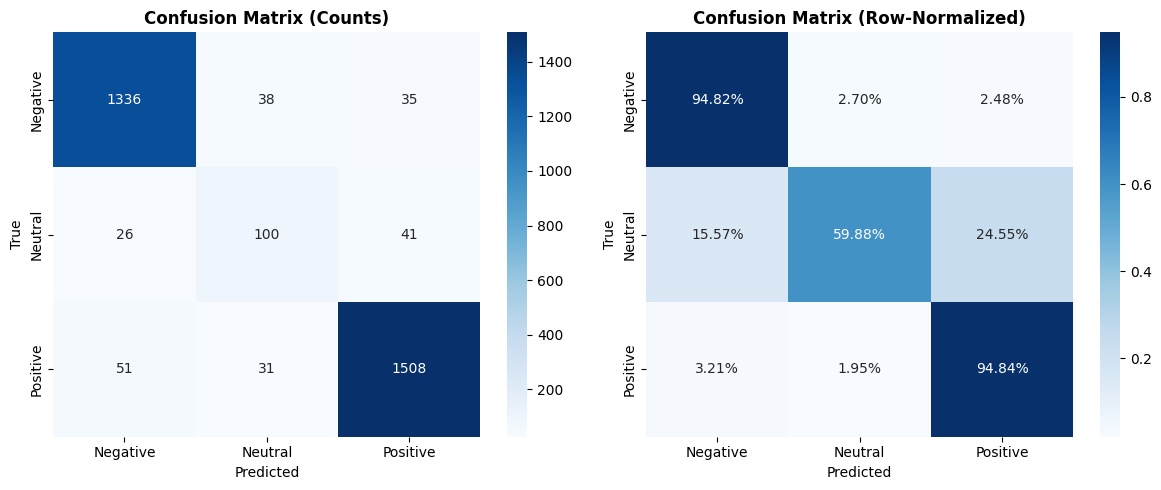

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes_names = ['Negative', 'Neutral', 'Positive']

cm = confusion_matrix(y_test, y_pred_pho)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix (counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_names, yticklabels=classes_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# Confusion matrix (normalized by row)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes_names, yticklabels=classes_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Row-Normalized)', fontweight='bold')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

## 11. Per f1-score class Bar graph

In [22]:
import pandas as pd
classes_names = ['Negative', 'Neutral', 'Positive']

# 1) Tính metric PhoBERT
p_pc, r_pc, f_pc, _ = precision_recall_fscore_support(
    y_test, y_pred_pho, average=None, zero_division=0
)
p_w, r_w, f_w, _ = precision_recall_fscore_support(
    y_test, y_pred_pho, average='weighted', zero_division=0
)

# 2) Chuẩn hóa data thành bảng (per-class + overall)
rows = []

# Per-class PhoBERT
for i, cls in enumerate(classes_names):
    rows.append({
        "Model": "PhoBERT",
        "Class": cls,
        "Precision": p_pc[i] * 100,
        "Recall": r_pc[i] * 100,
        "F1": f_pc[i] * 100
    })

# Overall PhoBERT (weighted)
rows.append({
    "Model": "PhoBERT",
    "Class": "Overall (weighted)",
    "Precision": p_w * 100,
    "Recall": r_w * 100,
    "F1": f_w * 100
})

# Baseline per-class
rows.append({"Model": "Baseline", "Class": "Negative",
             "Precision": baseline['precision'][0],
             "Recall":    baseline['recall'][0],
             "F1":        baseline['f1'][0]})
rows.append({"Model": "Baseline", "Class": "Neutral",
             "Precision": baseline['precision'][1],
             "Recall":    baseline['recall'][1],
             "F1":        baseline['f1'][1]})
rows.append({"Model": "Baseline", "Class": "Positive",
             "Precision": baseline['precision'][2],
             "Recall":    baseline['recall'][2],
             "F1":        baseline['f1'][2]})
rows.append({"Model": "Baseline", "Class": "Overall (weighted)",
             "Precision": baseline['precision'][3],
             "Recall":    baseline['recall'][3],
             "F1":        baseline['f1'][3]})

df_comp = pd.DataFrame(rows)
df_comp

,Model,Class,Precision,Recall,F1
0,PhoBERT,Negative,94.550602,94.819021,94.684621
1,PhoBERT,Neutral,59.171598,59.880240,59.523810
2,PhoBERT,Positive,95.202020,94.842767,95.022054
3,PhoBERT,Overall (weighted),93.011581,92.987997,92.999423
4,Baseline,Negative,87.690000,93.540000,90.520000
5,Baseline,Neutral,50.000000,25.750000,33.990000
6,Baseline,Positive,91.690000,90.940000,91.320000
7,Baseline,Overall (weighted),87.710000,88.660000,87.940000


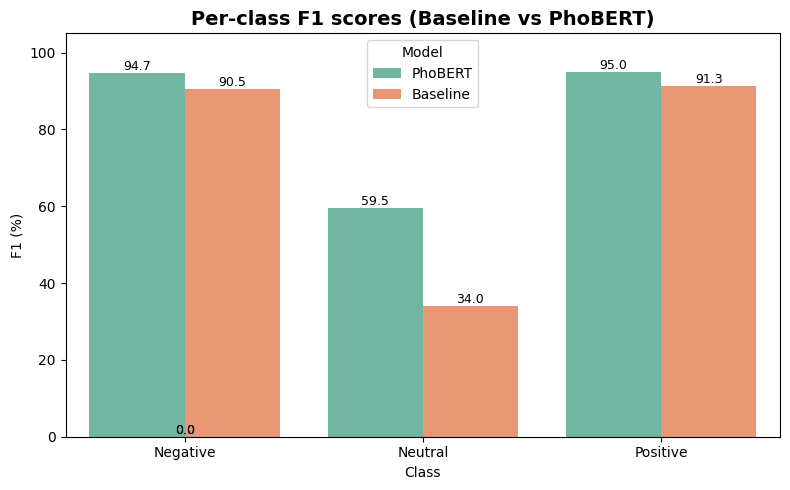

In [23]:
import matplotlib.pyplot as plt
import pandas as pd


df_plot = df_comp[df_comp["Class"].isin(['Negative', 'Neutral', 'Positive'])]

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_plot, x="Class", y="F1", hue="Model", palette="Set2")


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1f}",
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, rotation=0)

plt.title("Per-class F1 scores (Baseline vs PhoBERT)", fontsize=14, fontweight='bold')
plt.ylabel("F1 (%)")
plt.xlabel("Class")
plt.ylim(0, 105)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [24]:
import json
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

# 1) Lưu predictions
df_preds = pd.DataFrame({
    "text": test_sents,
    "true_label": [label_map[y] for y in y_test],
    "pred_label": [label_map[y] for y in y_pred_pho],
    "true_id": y_test,
    "pred_id": y_pred_pho,
})
preds_path = "phobert_predictions.csv"
df_preds.to_csv(preds_path, index=False, encoding="utf-8")

# 2) Tính metrics
p_c, r_c, f_c, sup_c = precision_recall_fscore_support(
    y_test, y_pred_pho, average=None, zero_division=0
)
p_w, r_w, f_w, _ = precision_recall_fscore_support(
    y_test, y_pred_pho, average="weighted", zero_division=0
)
p_m, r_m, f_m, _ = precision_recall_fscore_support(
    y_test, y_pred_pho, average="macro", zero_division=0
)

cm = confusion_matrix(y_test, y_pred_pho)

metrics = {
    "per_class": [
        {
            "class": classes_names[i],
            "precision": float(p_c[i]),
            "recall": float(r_c[i]),
            "f1": float(f_c[i]),
            "support": int(sup_c[i]),
        } for i in range(len(classes_names))
    ],
    "overall": {
        "weighted": {"precision": float(p_w), "recall": float(r_w), "f1": float(f_w)},
        "macro":    {"precision": float(p_m), "recall": float(r_m), "f1": float(f_m)},
    },
    "confusion_matrix": cm.tolist(),
}

metrics_path = "phobert_metrics.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

# 3) In summary
print("=== SUMMARY (PhoBERT) ===")
print(f"Overall (weighted) P/R/F1: {p_w*100:.2f}% / {r_w*100:.2f}% / {f_w*100:.2f}%")
print(f"Overall (macro)    P/R/F1: {p_m*100:.2f}% / {r_m*100:.2f}% / {f_m*100:.2f}%")
print("\nPer-class F1:")
for i, cls in enumerate(classes_names):
    print(f"  {cls:<8}: F1 = {f_c[i]*100:.2f}% (P={p_c[i]*100:.2f}%, R={r_c[i]*100:.2f}%, Sup={sup_c[i]})")

print(f"\nSaved predictions to: {preds_path}")
print(f"Saved metrics to:     {metrics_path}")

=== SUMMARY (PhoBERT) ===
Overall (weighted) P/R/F1: 93.01% / 92.99% / 93.00%
Overall (macro)    P/R/F1: 82.97% / 83.18% / 83.08%

Per-class F1:
  Negative: F1 = 94.68% (P=94.55%, R=94.82%, Sup=1409)
  Neutral : F1 = 59.52% (P=59.17%, R=59.88%, Sup=167)
  Positive: F1 = 95.02% (P=95.20%, R=94.84%, Sup=1590)

Saved predictions to: phobert_predictions.csv
Saved metrics to:     phobert_metrics.json
